## imports

In [1]:
import os
from io import StringIO
import subprocess

import time
import math
import pandas as pd

# rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

#ase
from ase import io
from ase.units import Hartree,_amu, Bohr,kB,eV
from ase.optimize import BFGS
from xtb.libxtb import VERBOSITY_MINIMAL,VERBOSITY_MUTED

#xtb
from xtb.ase.calculator import XTB
from xtb.interface import Calculator, Param

In [2]:
os.environ['XTBPATH'] ="/home/sat/anaconda3/envs/py310gpaw/share/xtb"

## packages

## functionality

In [3]:
def get_dict(entry):
    d={}
    d['2dsdf']=entry[0].splitlines()
    for item in entry[1:]:
        tmp=list(item.replace('\n','').split('>'))
        #print (tmp,len(tmp))
        d[tmp[0]]=tmp[1]
    return d

In [4]:
def parse_db(f): #sdf-reader
    dbfile =open(f,mode='r') #"../DB/COCONUT_2022_01_2D.SDF"
    dbstr=dbfile.read()
    dbfile.close()
    dbitems=dbstr.split('$$$$\n')
    for num,item in enumerate(dbitems):
        dbitems[num]=list(item.split('\n> <'))
    dbparsed=[]
    for item in dbitems:
        d=get_dict(item)
        dbparsed.append(d)
    #del dbparsed[-1]
    return pd.DataFrame.from_dict(dbparsed,orient='columns')

In [5]:
def embend_confs(smile,n):
    mol=Chem.MolFromSmiles(smile)
    #print(Chem.MolToSmiles(mol))
    try:
        molHs=Chem.AddHs(mol)
    except Exception as e:
#        print(e)
        print("    could not add H's: writing CH4 dummy")
        mol=Chem.MolFromSmiles('C')
        molHs=Chem.AddHs(mol)
        #print(Chem.MolToSmiles(molHs))
    #AllChem.EmbedMolecule(molHs)
    #print("!!!!!!",molHs)
    params = AllChem.ETKDGv3()
    try:
        #print('T R Y')
        AllChem.EmbedMultipleConfs(molHs, numConfs = n , params = params)
        #print(molHs.GetNumConformers())
    except Exception as e:
        print(e)
        #print('E X C')
    if molHs.GetNumConformers()==0:
        print("    embedding failed: starting with random coordinates")
        params.useRandomCoords=True
#        params.maxAttempts=10000
#        params.boxSizeMult=5.0
#        params.enforceChirality=False
#        params.ignoreSmoothingFailures=True
        AllChem.EmbedMultipleConfs(molHs, numConfs = n, params = params )
        print("    number of conformers by random coordinates",molHs.GetNumConformers())
        if molHs.GetNumConformers()==0:
            print("    could not embed multiple confs: writing CH4 dummy")
            mol=Chem.MolFromSmiles('C')
            molHs=Chem.AddHs(mol)
            AllChem.EmbedMultipleConfs(molHs, numConfs = n , params = params)
    return molHs

In [6]:
def get_hlgap(res):
    eigen=res.get_orbital_eigenvalues()
    occup=res.get_orbital_occupations()
    thresh=1e-2
    for num,(e,o) in enumerate(zip(eigen,occup)):
        if o<thresh:
            lumo=eigen[num]
            homo=eigen[num-1]
            gap=(lumo-homo)*Hartree
            break
    return gap

In [7]:
def boltzweight(gap,ene):
    bsum=0.0
    temp=300.00
    #print(ene.values())
    minfree=min(ene.values())
    for e in ene.values():
        bsum+= math.exp( -((e - minfree) * Hartree ) / (kB * temp) )
    bweight={}
    for n,e in enumerate(ene.values()):
        bweight[n]= math.exp( -((e - minfree) * Hartree ) / (kB * temp) ) / bsum
    #print(bweight)
    gapw=0.0
    for b,g in zip(bweight.values(),gap.values()):
        gapw+=b*g
    return gapw

In [8]:
def calc_gap(mol,method,accuracy,temp):
    gap_d={}
    ene_d={}
    for c in range(mol.GetNumConformers()):
        strio=StringIO(Chem.MolToMolBlock(mol,confId=c))
        molase=io.read(strio,format='mol')
        strio.close()
        molase.calc = XTB(method=method,accuracy=accuracy,electronic_temperature=temp,max_iterations=300,) #GFNFF
        opt = BFGS(molase,trajectory=None,logfile=None) #'BFGS_'+method+'_confID_'+str(c)+'.traj') 
        opt.run(fmax=1.0e-03*molase.get_number_of_atoms())
        numbers=molase.get_atomic_numbers()
        positions=molase.get_positions()/Bohr
        if method=="GFN0-xTB":
            calc = Calculator(Param.GFN0xTB, numbers, positions)
        if method=="GFN1-xTB":
            calc = Calculator(Param.GFN1xTB, numbers, positions)
        if method=="GFN2-xTB":
            calc = Calculator(Param.GFN2xTB, numbers, positions)
        if method=="IPAE-xTB":
            calc = Calculator(Param.IPEAxTB, numbers, positions)
        calc.set_electronic_temperature(temp)
        calc.set_accuracy(accuracy)
        calc.set_verbosity(VERBOSITY_MUTED)
        res = calc.singlepoint()
        ene=res.get_energy()
        gap=get_hlgap(res)
        #print("finished conformer ",format(c+1, "2d"),"/",mol.GetNumConformers()," with HL-gap", format(gap, "7.3f"))
        gap_d[c]=gap
        ene_d[c]=ene
    #print(gap_d, ene_d)
    gapw=boltzweight(gap_d,ene_d)
    return gapw

## parse coconut-db

In [9]:
pref=subprocess.getoutput("pwd")+"/../data/db_split/"
coconut_df=parse_db(f=pref+"/1366_COCONUT_2022_01_2D.SDF") 
coconut_df

,2dsdf,coconut_id,inchi,inchikey,SMILES,sugar_free_smiles,molecular_formula,molecular_weight,citationDOI,textTaxa,...,number_of_nitrogens,number_of_oxygens,number_of_rings,total_atom_number,bond_count,found_in_databases,murko_framework,alogp,apol,topoPSA
0,"[, CDK 04252213402D, , 8 12 0 0 0 ...",CNP0001514,"InChI=1S/C8H4/c1-2-5-3(1)7-4(1)6(2)8(5)7/h1-3,6H",KWFAQPWLROZBAY-UHFFFAOYSA-N,C1=2C3=C4C1C5C2C3C45,C1=2C3=C4C1C5C2C3C45,C8H4,100.11765018960718,[],[notax],...,0,0,,12,12,"[fooddb, pubchem]",C1=2C3=C4C1C5C2C3C45,0.4171999999999998,16.747172,0.0


## input and run

In [13]:
dbentry =0         # idx of db entry
nconfs  =10         # number of conformers to generate for the molecule
accuracy=1.0       #smaller means higher accuracy from  1000 to 0.0001
temp    =300.0     #electronic temperature
method="GFN2-xTB"  # the tight-binding method to use ["GFN0-xTB","GFN1-xTB","GFN2-xTB","IPEA-xTB"]

smile=coconut_df['SMILES'].iloc[dbentry]
smile="C" #smile string of the molecule 
confs= embend_confs(smile=smile,n=nconfs) # the molecule under investigation including conformers
confs.GetNumConformers()

10

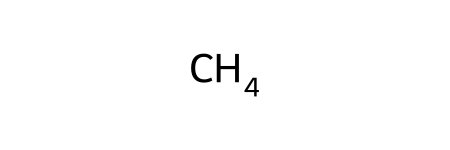

In [14]:
mm=Chem.MolFromSmiles(smile)
mm

In [15]:
c=confs.GetNumConformers()
c

10

In [16]:
gap=calc_gap(mol=confs,method=method,accuracy=accuracy,temp=temp)
print(gap)

/home/sat/anaconda3/envs/py310electronic_gaps/lib/python3.10/site-packages/ase/atoms.py:967: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',
/tmp/ipykernel_23991/130611130.py:9: ResourceWarning: unclosed file <_io.TextIOWrapper name='/dev/null' mode='a' encoding='UTF-8'>
  opt = BFGS(molase,trajectory=None,logfile=None) #'BFGS_'+method+'_confID_'+str(c)+'.traj')


17.353466285473402


## example loop in python >>> should be done with CWL scatter 

In [ ]:
#example loop in python >>> should be done with CWL scatter 
gaps={}
t0=time.time()
ra=range(385,387)
#ra=range(0,407270,200)
#ra=range(1201,1402,200)
for idx,dbentry in zip(coconut_df.iloc[ra].index,coconut_df['SMILES'].iloc[ra]): #error handling for "0"
    #print(dbentry)
    #CWL-loop around this
    t0i=time.time()
    confs= embend_confs(smile=dbentry,n=nconfs) # the molecule under investigation including conformers
    #print(confs.GetNumConformers())
    gap=calc_gap(mol=confs,method=method,accuracy=accuracy,temp=temp)
    gaps[idx]=gap
    t1i=time.time()
    print('finished molecule: ',idx,dbentry,gap,t1i-t0i)
t1=time.time()
dt=t1-t0
print(dt)

## old stuff not needed

In [ ]:
dt/60/60

In [ ]:
gaps_0=gaps
gaps_0

In [ ]:
gaps_df=pd.DataFrame.from_dict(gaps,orient='index')
gaps_df

In [ ]:
ax = gaps_df.plot.hist(bins=50, alpha=0.5)

In [ ]:
#accuracy
#   0.01 45.7743270397186 s 1.689028994193965 eV
#   1.00 31.0500078201293 s 1.689004691284549 eV
# 100.00 25.1419575214386 s 1.716191329441809 eV
#gap
# 1.7158121835260607 eV #  5
# 1.6964008849101262 eV # 10
# 1.7274967423935927 eV #100